# Deep embedded clustering

In [2]:
# machine learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
from sklearn.utils import Bunch

#standard libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns



In [3]:
# import modules from utils 

import sys
import os

# Dynamically add the 'utils' folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../source/')))

# Now, you can import the functions
from utils.autoencoder import Autoencoder

# Import Covariates dataframe

In [4]:
Covariates_df = pd.read_csv("../../data/cleaned_data/Covariates.csv")
Covariates_df["PST/Sol."].head()

0     3.211407
1    24.448314
2     9.807453
3     7.243925
4     6.893438
Name: PST/Sol., dtype: float64

In [19]:
# Identify categorical columns
categorical_columns = Covariates_df.select_dtypes(include=['object', 'string']).columns
categorical_columns = categorical_columns.drop(["MunicipalityName", "Canton", "mountain_binary"])
print(categorical_columns)
# Apply encoding only to categorical columns
encoded_categorical = pd.get_dummies(Covariates_df[categorical_columns])
print(encoded_categorical)
# Concatenate with untouched columns
non_categorical = Covariates_df.drop(columns=categorical_columns)
non_categorical = Covariates_df.drop(columns=["MunicipalityName", "MunicipalityNumber", "Canton", "mountain_binary"])
transformed_df = pd.concat([non_categorical, encoded_categorical], axis=1).drop(columns=categorical_columns)

print("Transformed DataFrame:")
transformed_df.head()

Index(['urban_typo', 'mountain_type', 'language'], dtype='object')
      urban_typo_Centrally located rural municipality (32)  \
0                                                 False      
1                                                 False      
2                                                 False      
3                                                 False      
4                                                 False      
...                                                 ...      
2126                                              False      
2127                                              False      
2128                                              False      
2129                                              False      
2130                                              False      

      urban_typo_High-density peri-urban municipality (21)  \
0                                                 False      
1                                                 False      
2 

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
0,1998.0,444.0,335.0,392.0,1232.0,357.0,848.0,25.075949,442.0,39.0,...,False,False,False,False,True,False,False,True,False,False
1,12859.0,1884.0,1260.0,2481.0,7587.0,2235.0,5412.0,377.385470,6920.0,47.0,...,False,False,False,False,True,False,False,True,False,False
2,5678.0,1197.0,706.0,1317.0,3334.0,921.0,2327.0,86.126344,1014.0,34.0,...,False,False,False,False,True,False,False,True,False,False
3,3974.0,764.0,555.0,832.0,2244.0,675.0,1552.0,47.609905,1021.0,93.0,...,False,False,False,False,True,False,False,True,False,False
4,3963.0,809.0,580.0,817.0,2329.0,632.0,1580.0,74.868902,1478.0,29.0,...,False,False,False,False,True,False,False,True,False,False


In [20]:


# Extract the numeric data from the DataFrame
df = transformed_df
df =df.replace(np.nan, 0)
X = df.to_numpy()  # Convert to numpy array

# Create a Bunch object with the DataFrame data and the index as the target
data = Bunch(data=X, target=Covariates_df.index)
print(f"Data type: {type(data)}")

# Convert the data to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]  # Number of features (e.g., 4 for Iris dataset)
encoding_dim = 2  # Number of dimensions in the embedded space (latent space)
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Autoencoder
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    decoded, encoded = model(X_tensor)
    loss = criterion(decoded, X_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Extract the learned embeddings (latent space)
with torch.no_grad():
    model.eval()
    _, encoded_features = model(X_tensor)

# Apply KMeans clustering to the embeddings
encoded_features = encoded_features.numpy()  # Convert to numpy for KMeans
kmeans = KMeans(n_clusters=9)
kmeans.fit(encoded_features)
labels = kmeans.labels_

# Plot the clustered data in the 2D embedded space
plt.scatter(encoded_features[:, 0], encoded_features[:, 1], c=labels, cmap='magma')
plt.title('Deep Embedded Clustering')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()
labels

Data type: <class 'sklearn.utils._bunch.Bunch'>


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [26]:
Covariates_final_df = Covariates_df.copy()
Covariates_final_df["label"] = labels
Covariates_final_df.head()

,MunicipalityNumber,MunicipalityName,urban_typo,mountain_type,mountain_binary,Population,language,Canton,Yes [nbr],No [nbr],...,Small right-wing parties,Municipal_rev [CHF],revenue_per_capita [CHF],elec_consumption_households_mwh_per_year_per_capita,elec_consumption_households_mwh_per_year,elec_consumption_mwh_per_year_per_capita,elec_consumption_mwh_per_year,mean_price (cts/kWh),std_price (cts/kWh),label
0,1.0,Aeugst am Albis,Low-density peri-urban municipality (23),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,1998.0,german,Zürich,444.0,335.0,...,75.687016,109921000.0,NaN,2.9119,5811,4.4623,8905,26.231762,2.464933,5
1,2.0,Affoltern am Albis,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,12859.0,german,Zürich,1884.0,1260.0,...,191.375321,435719400.0,80080.757214,1.6492,21056,4.1840,53420,26.231762,2.464933,6
2,3.0,Bonstetten,Medium-density peri-urban municipality (22),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,5678.0,german,Zürich,1197.0,706.0,...,77.173402,251102000.0,99960.987261,1.7356,9827,2.8006,15857,26.231762,2.464933,5
3,4.0,Hausen am Albis,Medium-density peri-urban municipality (22),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,3974.0,german,Zürich,764.0,555.0,...,60.419112,165486900.0,100968.212325,2.3004,9128,3.9176,15545,26.231762,2.464933,5
4,5.0,Hedingen,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,3963.0,german,Zürich,809.0,580.0,...,82.008137,177331200.0,106826.024096,2.1157,8335,5.3155,20941,26.231762,2.464933,5


In [27]:
group = Covariates_final_df.groupby("label")[numeric_columns].mean()
group

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,PES,Small right-wing parties,Municipal_rev [CHF],revenue_per_capita [CHF],elec_consumption_households_mwh_per_year_per_capita,elec_consumption_households_mwh_per_year,elec_consumption_mwh_per_year_per_capita,elec_consumption_mwh_per_year,mean_price (cts/kWh),std_price (cts/kWh)
label,,,,,,,,,,,,,,,,,,,,,
0,995.310636,138.224317,147.780884,201.225681,580.925422,181.743191,408.420233,11.880675,386.012278,48.639290,...,98.986004,29.694341,3.407507e+07,55094.305191,3.195617,4800.944913,6.087562,1.076315e+04,22.202626,3.539455
1,191482.000000,29756.000000,9616.500000,32883.500000,123082.000000,32626.000000,88992.000000,16889.502483,186026.000000,32.500000,...,43316.327039,5305.950615,7.370894e+09,92219.973846,1.134950,212257.500000,6.653100,1.229951e+06,27.387070,2.974122
2,433989.000000,86847.000000,25386.000000,73514.000000,284691.000000,62012.000000,204411.000000,26041.886202,491193.000000,177.000000,...,85680.157477,2496.427306,1.837301e+10,92126.709355,1.163600,504869.000000,5.916900,2.567314e+06,22.953061,2.454929
3,20903.152174,3124.847826,1704.282609,4011.239130,12287.347826,3751.434783,8878.391304,936.920278,13120.065217,68.065217,...,3117.902090,488.925228,8.702042e+08,112848.305890,1.491300,29640.086957,4.754589,9.877124e+04,27.267322,3.310782
4,133487.666667,27808.000000,7798.666667,24039.666667,84343.000000,20674.666667,61979.666667,5364.199973,128554.666667,206.666667,...,30700.953975,1030.563172,4.502059e+09,78980.741355,1.270000,167561.000000,5.157533,6.854373e+05,30.219486,3.632547
5,5073.199513,693.900243,588.676399,1009.362530,2948.301703,917.248175,2102.002433,113.727418,2239.789604,89.957921,...,547.125646,123.268077,1.792343e+08,86289.575856,2.160534,10817.294404,5.450990,2.841326e+04,26.886478,3.798715
6,11294.173913,1649.591304,1168.886957,2202.252174,6604.252174,2109.034783,4771.791304,391.660161,6433.729730,101.225225,...,1480.699027,237.974806,4.508629e+08,105348.533375,1.775875,20270.469565,5.002755,6.057933e+04,26.697140,3.401439
7,65247.333333,12213.666667,5048.333333,10964.000000,40341.666667,11682.666667,30930.000000,2617.223340,68948.666667,166.666667,...,12513.698856,292.285055,2.812149e+09,111304.257599,1.523600,98227.333333,6.627100,4.112567e+05,24.501682,2.917679
8,33746.428571,6022.142857,3357.857143,6325.000000,20227.285714,6586.571429,15175.857143,1154.043171,22398.714286,159.857143,...,5748.495335,723.099544,1.489755e+09,118865.258449,1.580557,52199.000000,4.958300,1.641740e+05,27.559839,3.442888


In [42]:
for col in group.columns:
    group[col].plot(kind="bar")
    plt.title(col)
    plt.grid(axis="y")
    plt.show()

AttributeError: 'int' object has no attribute 'columns'

In [44]:
group.describe()

AttributeError: 'int' object has no attribute 'describe'

In [43]:
group_percentage = group.copy()
for col in group.columns:
    group_percentage[col] = group[col]/group[col].sum()
group_percentage

AttributeError: 'int' object has no attribute 'copy'

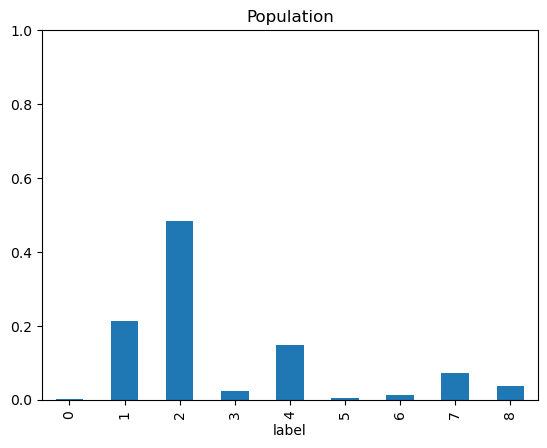

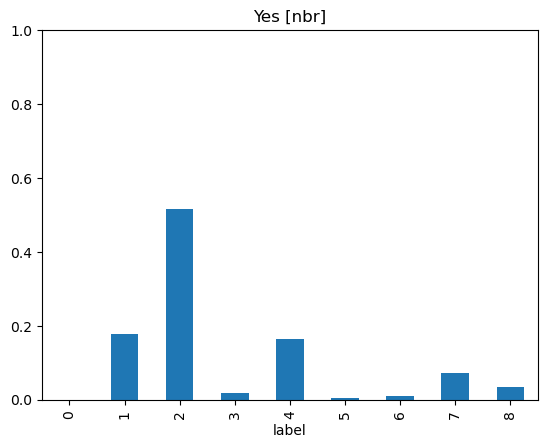

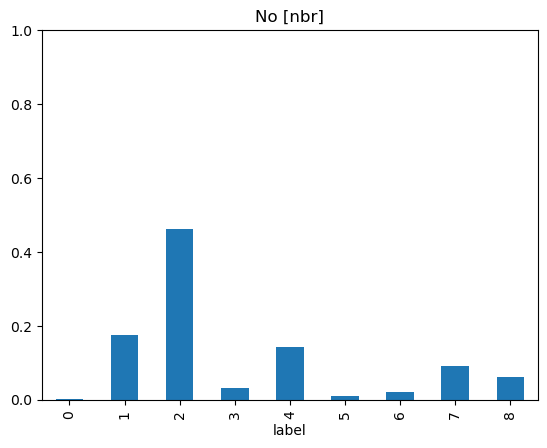

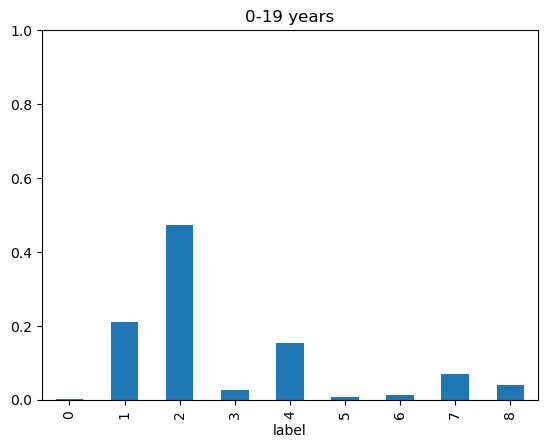

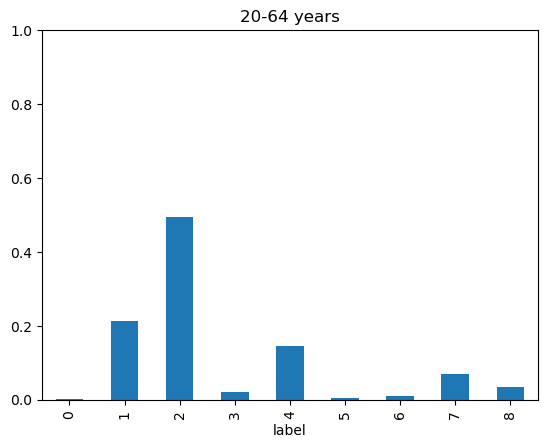

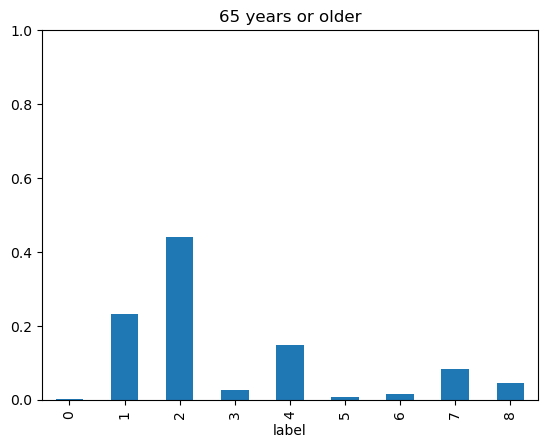

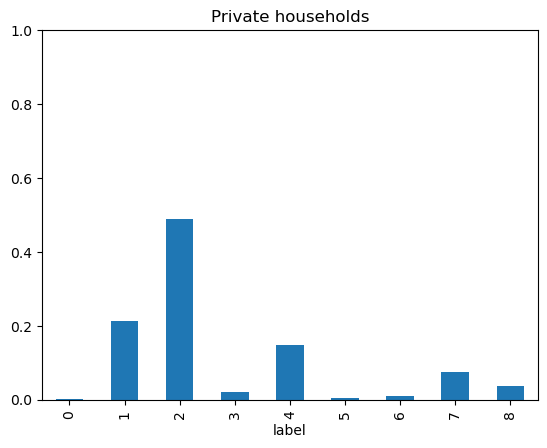

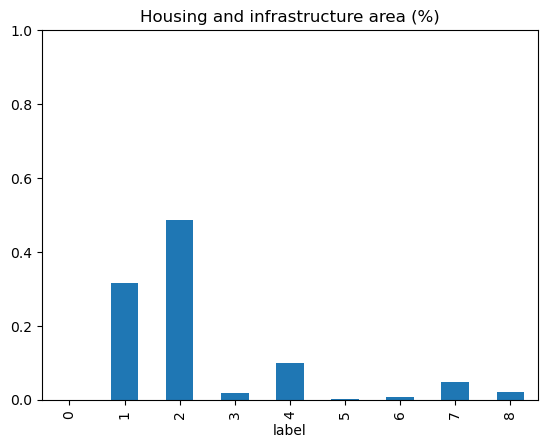

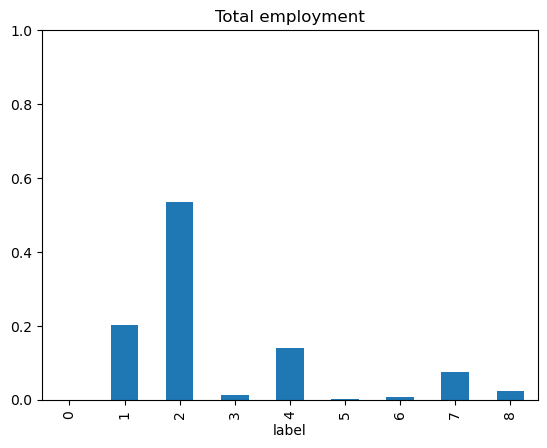

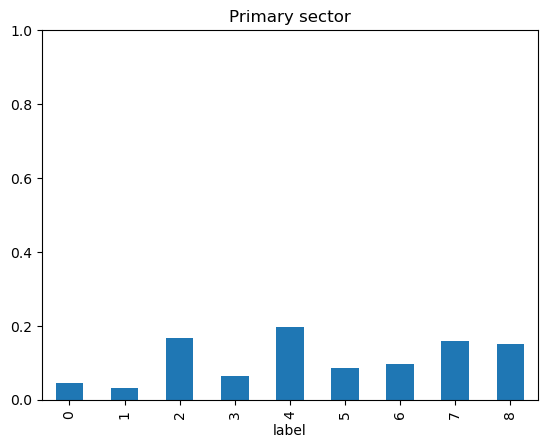

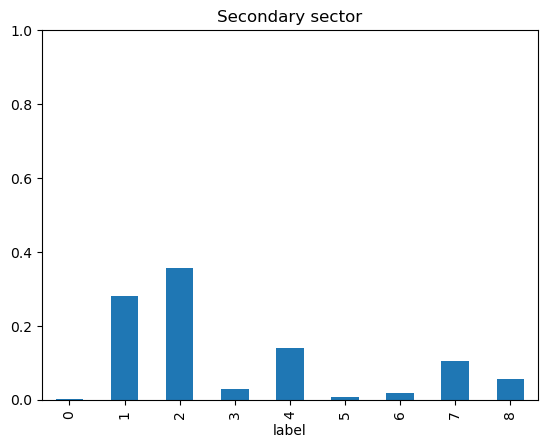

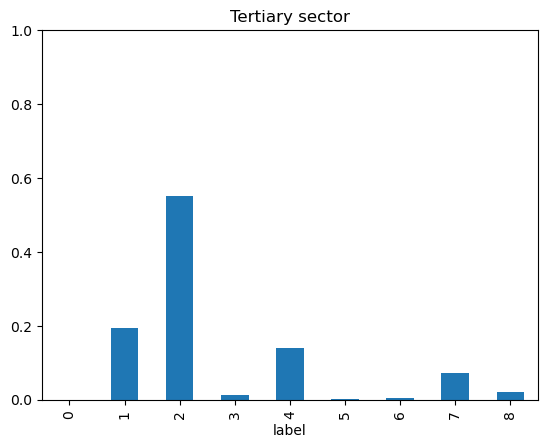

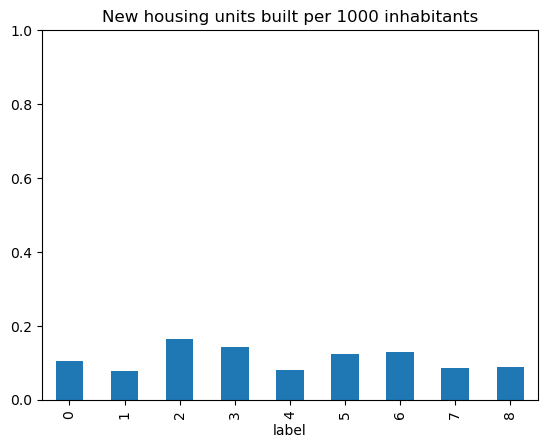

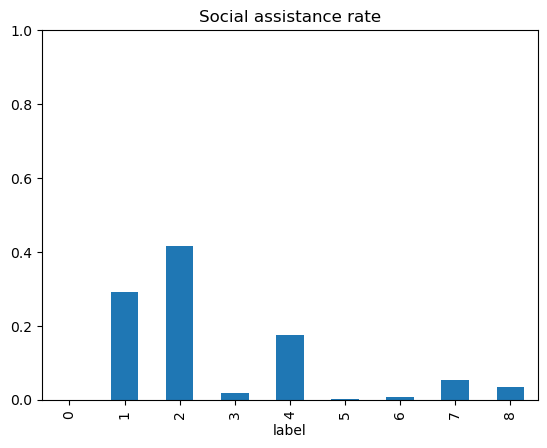

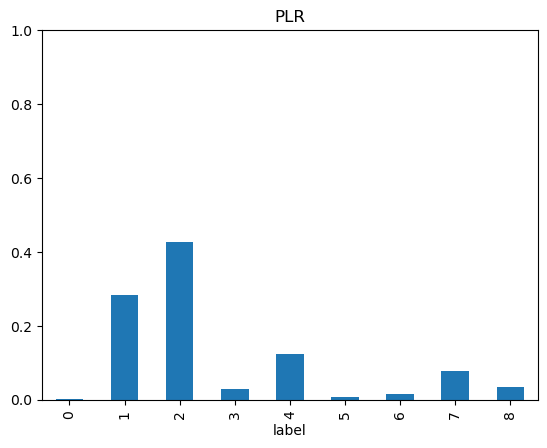

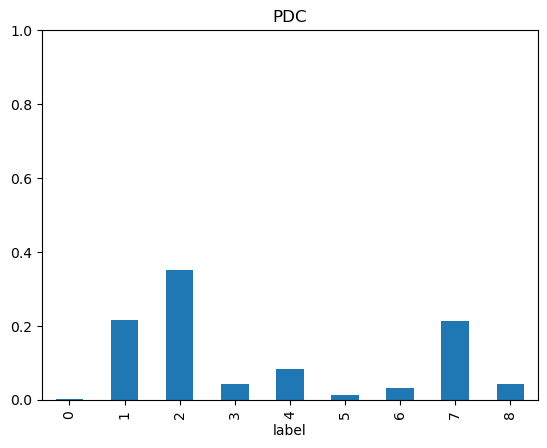

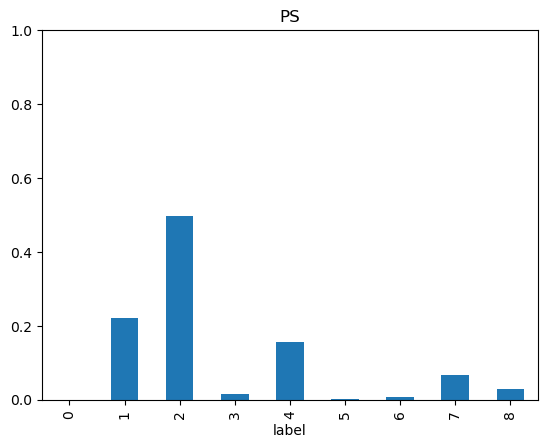

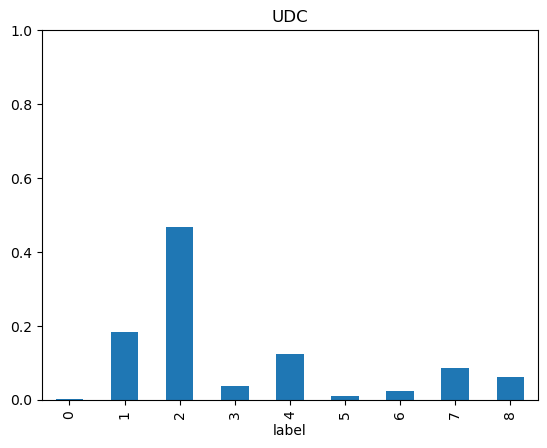

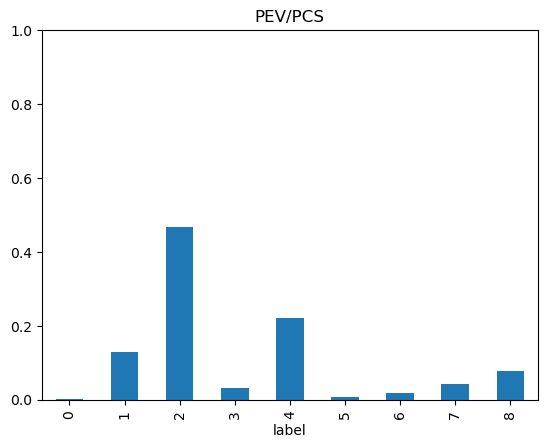

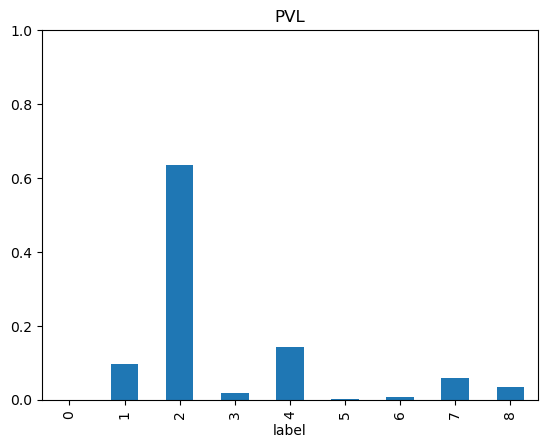

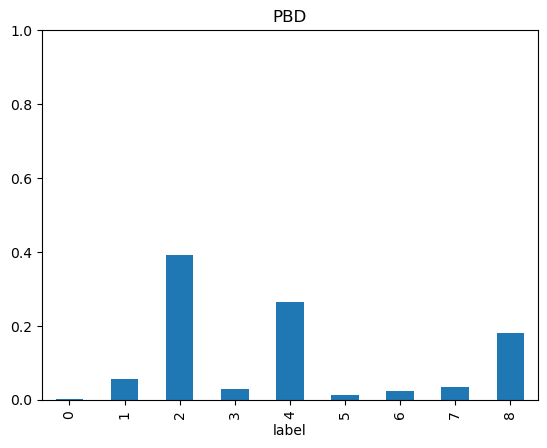

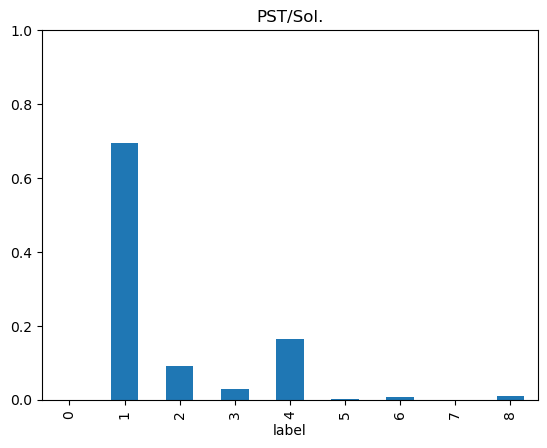

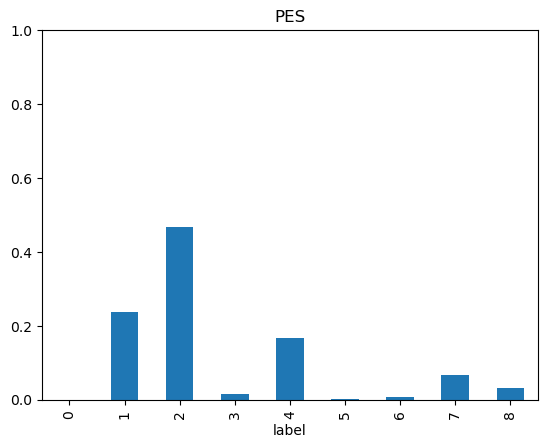

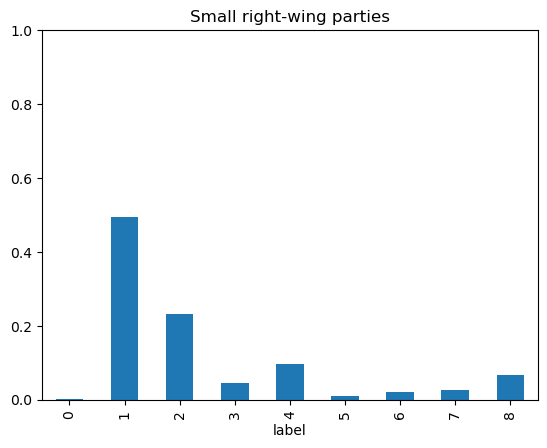

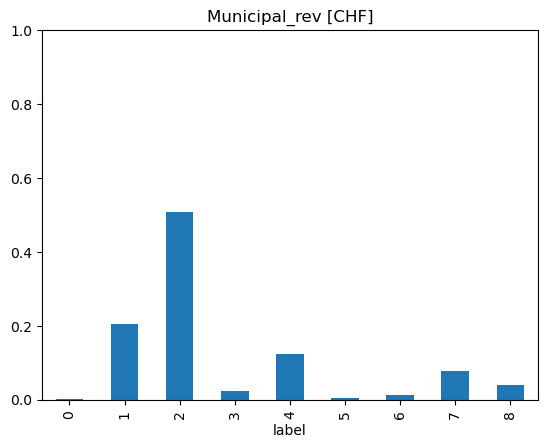

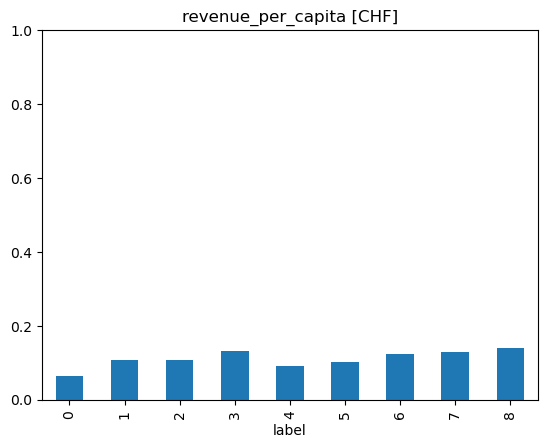

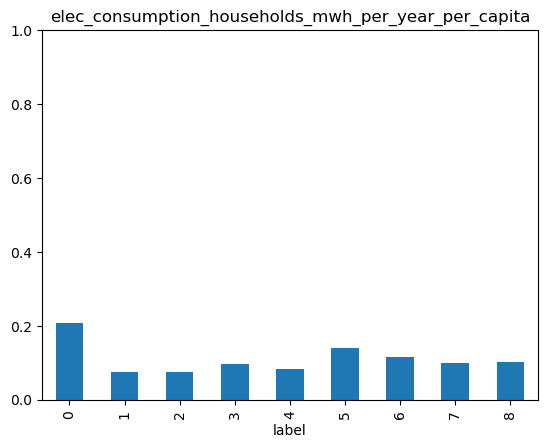

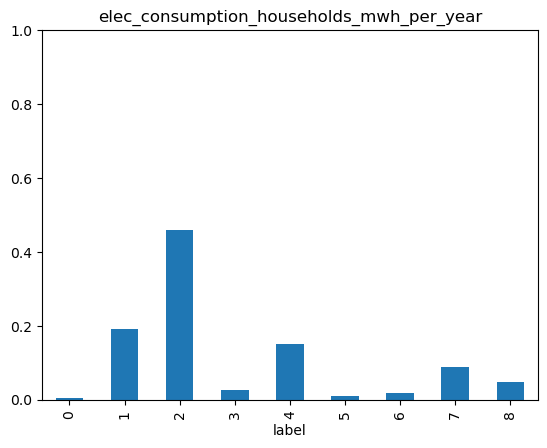

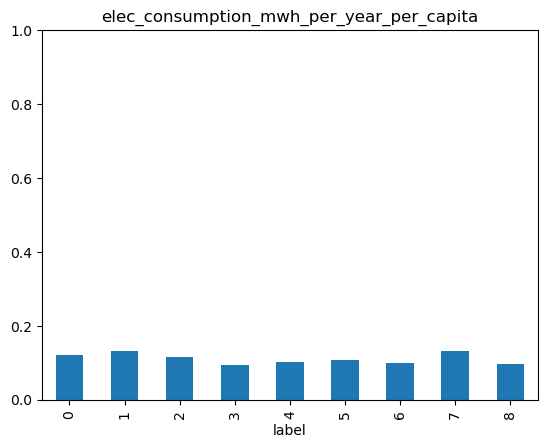

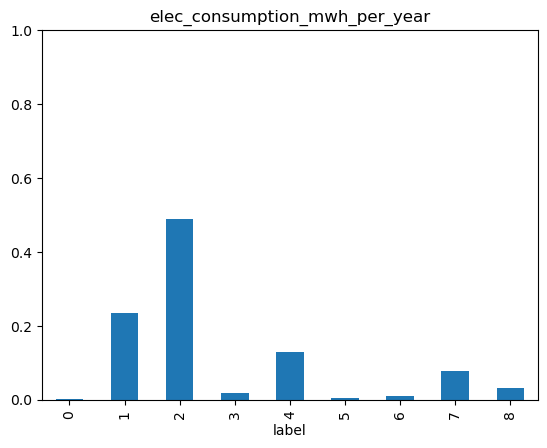

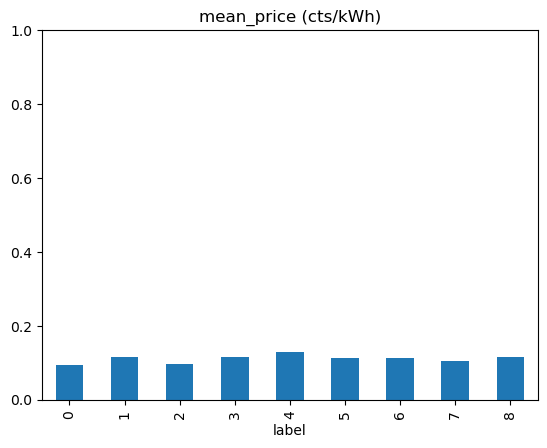

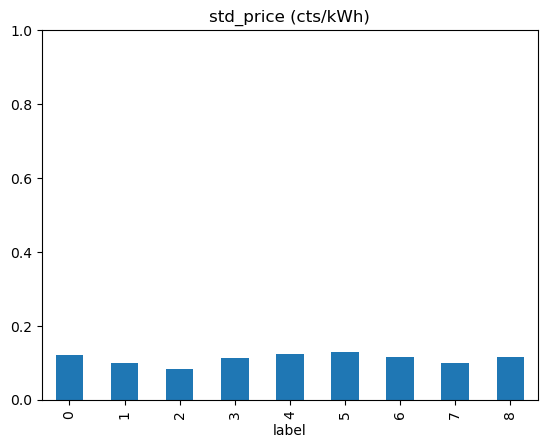

In [41]:
for index, row in group_percentage.iterrows():
    row.plot(kind="bar")
    plt.title(index)
    plt.ylim([0,1])
    plt.show()

C:\Users\godenzi\AppData\Local\Temp\ipykernel_14992\3374143607.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(group_percentage))  # Choose 'tab10' or another colormap


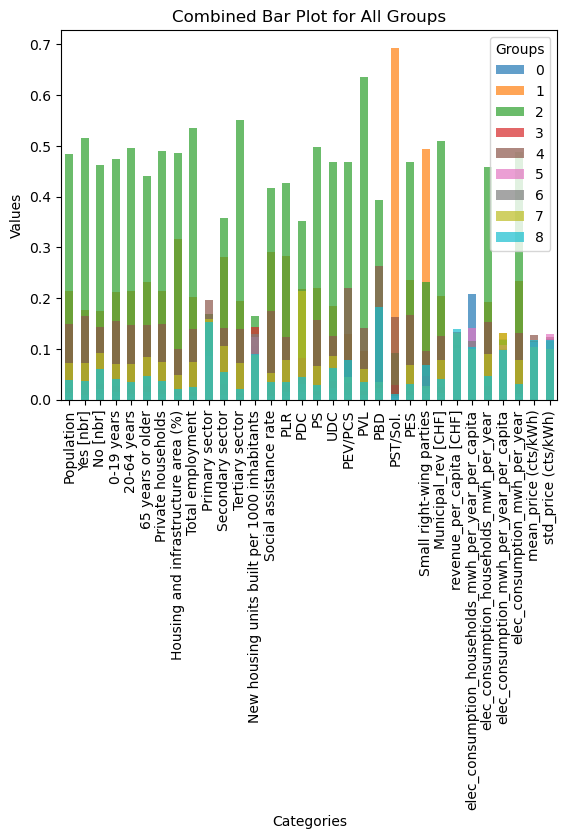

In [35]:
import matplotlib.cm as cm
# Generate a color map with distinct colors for each group
colors = cm.get_cmap('tab10', len(group_percentage))  # Choose 'tab10' or another colormap

# Plot all rows in a single bar plot
ax = None  # To keep track of the axes

# Loop through each row and assign a different color
for i, (index, row) in enumerate(group_percentage.iterrows()):
    ax = row.plot(
        kind="bar",
        ax=ax,
        color=colors(i),  # Assign a color from the colormap
        label=index,
        alpha=0.7
    )

# Add legend, title, and labels
plt.legend(title="Groups")
plt.title("Combined Bar Plot for All Groups")
plt.xlabel("Categories")
plt.ylabel("Values")
plt.show()



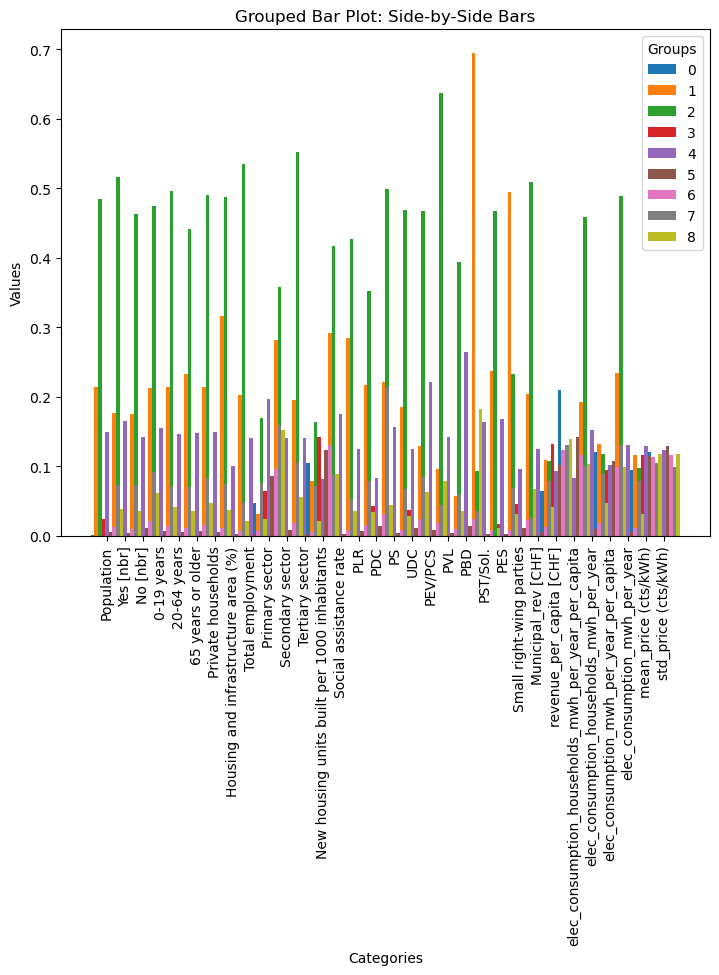

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Transpose the DataFrame to have categories on the x-axis
group_percentage = group_percentage.T

# Bar width and x positions
categories = group_percentage.index
groups = group_percentage.columns
x = np.arange(len(categories))  # X positions for categories
width = 0.2  # Width of each bar

# Plot side-by-side bars
fig, ax = plt.subplots(figsize=(8, 6))

# Generate distinct colors for each group
colors = plt.cm.tab10.colors  # Colormap with distinct colors

for i, group in enumerate(groups):
    ax.bar(
        x + i * width,  # Shift bars for each group
        group_percentage[group],
        width,
        label=group,
        color=colors[i % len(colors)]  # Cycle through colors
    )

# Add labels, title, legend, and ticks
ax.set_xlabel("Categories")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Plot: Side-by-Side Bars")
ax.set_xticks(x + width * (len(groups) - 1) / 2)  # Center the group labels
ax.set_xticklabels(categories)
ax.legend(title="Groups")

# Show the plot
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
